In [1]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [2]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/05-python-for-data/VADER-python-for-data.csv')


In [3]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-11,"Interesting and clear, the difficulty in the e...",4,completer,186,pos,"{'language': 'en', 'score': 0.9999988844000527}",en,"{'neg': 0.146, 'neu': 0.505, 'pos': 0.35, 'com...",0.7957,pos
1,1,2021-03-11,"great, i have learned basics of python from th...",5,completer,56,pos,"{'language': 'en', 'score': 0.9999970049413354}",en,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp...",0.6249,pos
2,2,2021-03-10,Recommended,5,completer,11,pos,"{'language': 'en', 'score': 0.8571409981818681}",en,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.2023,pos
3,3,2021-03-10,excellent,5,completer,9,pos,"{'language': 'ca', 'score': 0.8571389147750391}",ca,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.5719,pos
4,4,2021-03-10,Tamada sir is my biggest inspiration to comple...,5,completer,102,pos,"{'language': 'en', 'score': 0.9999982800455944}",en,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'comp...",0.5267,pos


In [4]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [5]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-11,"Interesting and clear, the difficulty in the e...",4,completer,186,pos,0.7957,pos
1,2021-03-11,"great, i have learned basics of python from th...",5,completer,56,pos,0.6249,pos
2,2021-03-10,Recommended,5,completer,11,pos,0.2023,pos
3,2021-03-10,excellent,5,completer,9,pos,0.5719,pos
4,2021-03-10,Tamada sir is my biggest inspiration to comple...,5,completer,102,pos,0.5267,pos
...,...,...,...,...,...,...,...,...
3111,2018-08-08,Good overall if you already have a grasp of py...,3,dropout,135,neu,0.1027,pos
3112,2018-08-06,good introductory course,5,dropout,24,pos,0.4404,pos
3113,2018-08-03,robotic teaching,2,dropout,16,neg,0.0000,neu
3114,2018-08-03,I recommend!,5,dropout,12,pos,0.4199,pos


In [6]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [7]:
# Drop null values

# df.dropna(inplace = True)

In [8]:
# Check for null values

# len(df[df['review'].isna()==True])

In [9]:
# Reset the index

# df = df.reset_index(drop = True)

In [10]:
# df

In [11]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data = d, x = "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

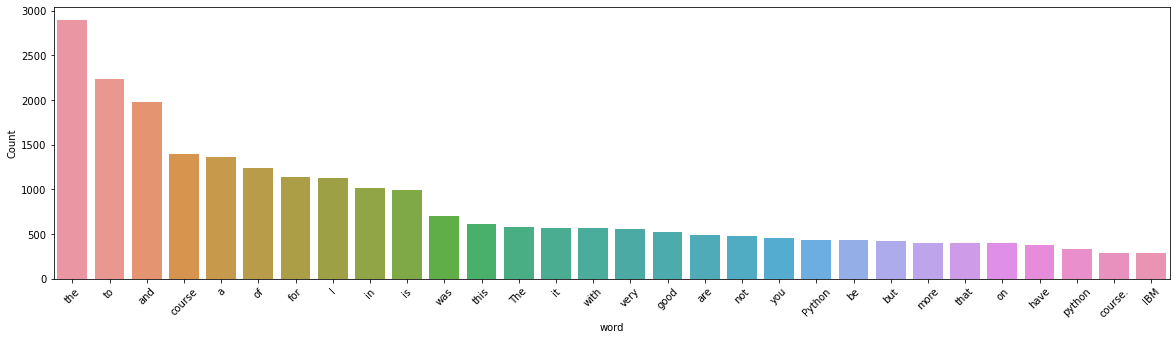

In [12]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [13]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    interesting and clear, the difficulty in the e...
1    great, i have learned basics of python from th...
2                                          recommended
3                                            excellent
4    tamada sir is my biggest inspiration to comple...
Name: preprocessed, dtype: object

In [14]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    interesting and clear the difficulty in the ex...
1    great i have learned basics of python from thi...
2                                          recommended
3                                            excellent
4    tamada sir is my biggest inspiration to comple...
Name: preprocessed, dtype: object

In [15]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice', 'bit'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head(20)

0     interesting clear difficulty exercises escalat...
1                          learned basics python course
2                                           recommended
3                                             excellent
4     tamada sir biggest inspiration complete course...
5                                         easy learning
6                                    python class thank
7     beginner python course covered lot understand ...
8     excellent class overview python starts basics ...
9     course goes informational video lab explaining...
10    class goes fast week 5 particularly challengin...
11                                                     
12                               awesome learn platform
13                                   perfectthanks much
14                                            many quiz
15                               course expected course
16                    syllabus acquired many new skills
17    poor quality videos basically sequence sli

In [16]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

In [17]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed
11,2021-03-08,Good for me,5,completer,11,pos,0.4404,pos,
33,2021-03-02,Good,4,completer,5,pos,0.4404,pos,
45,2021-02-28,good,5,completer,4,pos,0.4404,pos,
74,2021-02-13,great,3,completer,5,neu,0.6249,pos,
207,2020-12-03,good.,2,completer,5,neg,0.4404,pos,
...,...,...,...,...,...,...,...,...,...
2946,2019-01-01,Good,4,completer,4,pos,0.4404,pos,
2947,2018-12-31,Great,5,completer,5,pos,0.6249,pos,
2956,2018-12-26,it is good,3,completer,10,neu,0.4404,pos,
3046,2018-10-17,Very nice,5,completer,9,pos,0.4754,pos,


In [18]:
df = df[(df['preprocessed']!= "")]

In [19]:
# Reset the index

df = df.reset_index(drop = True)

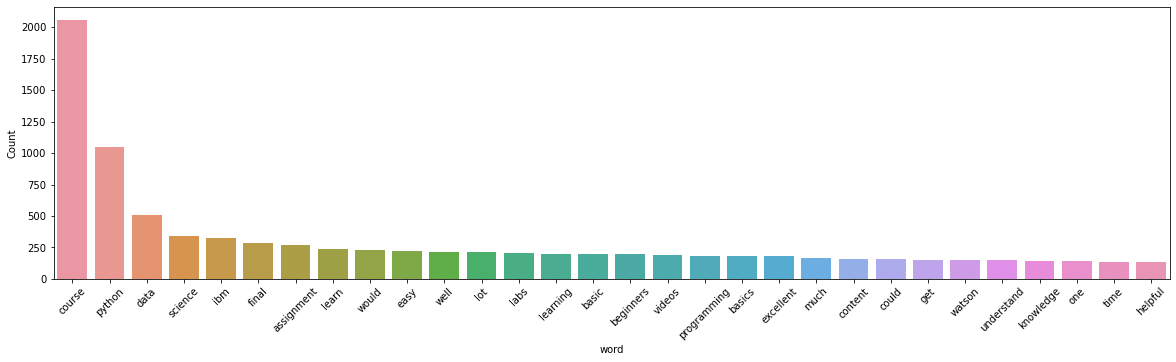

In [20]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [21]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [interesting, clear, difficulty, exercises, es...
1                    [learned, basics, python, course]
2                                        [recommended]
3                                          [excellent]
4    [tamada, sir, biggest, inspiration, complete, ...
Name: preprocessed, dtype: object

In [22]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(interesting, VBG), (clear, JJ), (difficulty,...
1    [(learned, VBN), (basics, NNS), (python, VBP),...
2                                 [(recommended, VBN)]
3                                    [(excellent, NN)]
4    [(tamada, NN), (sir, NN), (biggest, JJS), (ins...
Name: preprocessed, dtype: object

In [23]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(interesting, v), (clear, a), (difficulty, n)...
1    [(learned, v), (basics, n), (python, v), (cour...
2                                   [(recommended, v)]
3                                     [(excellent, n)]
4    [(tamada, n), (sir, n), (biggest, a), (inspira...
Name: preprocessed, dtype: object

In [25]:
df['preprocessed'][1]

[('learned', 'v'), ('basics', 'n'), ('python', 'v'), ('course', 'n')]

In [26]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head(8)

0    [interest, clear, difficulty, exercise, escala...
1                       [learn, basic, python, course]
2                                          [recommend]
3                                          [excellent]
4    [tamada, sir, big, inspiration, complete, cour...
5                                     [easy, learning]
6                               [python, class, thank]
7    [beginner, python, course, cover, lot, underst...
Name: preprocessed, dtype: object

In [27]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

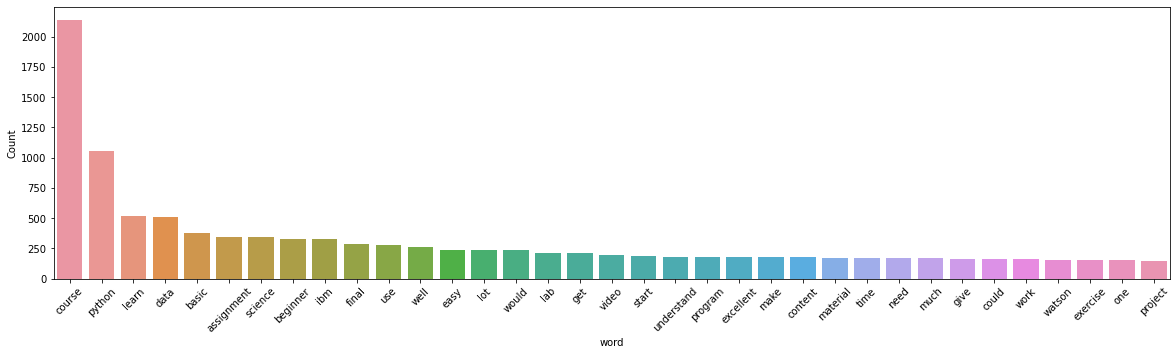

In [28]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [29]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [30]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [31]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [32]:
corpus[1]

[(3, 1), (13, 1), (14, 1), (15, 1)]

In [33]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [34]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 3, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.28)

In [35]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))
    
print('Topic 0: Content, Topic 1: Course delivery, Topic 2: Course provider')

Topic: 0
Word: 0.095*"course" + 0.063*"python" + 0.029*"data" + 0.026*"learn" + 0.023*"basic" + 0.021*"science" + 0.016*"beginner" + 0.012*"excellent" + 0.011*"well" + 0.010*"start"

Topic: 1
Word: 0.040*"course" + 0.023*"assignment" + 0.021*"final" + 0.013*"project" + 0.012*"would" + 0.009*"material" + 0.009*"time" + 0.008*"week" + 0.008*"video" + 0.008*"use"

Topic: 2
Word: 0.021*"course" + 0.019*"content" + 0.011*"ibm" + 0.010*"assignment" + 0.010*"lab" + 0.009*"easy" + 0.008*"video" + 0.008*"need" + 0.007*"quiz" + 0.007*"many"

Topic 0: Content, Topic 1: Course delivery, Topic 2: Course provider


### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [36]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.166976  0.028336       1        1  41.283784
1      0.043615 -0.103165       2        1  39.908137
2      0.123361  0.074829       3        1  18.808079, topic_info=           Term        Freq       Total Category  logprob  loglift
15       python  986.000000  986.000000  Default  30.0000  30.0000
99         data  419.000000  419.000000  Default  29.0000  29.0000
107     science  291.000000  291.000000  Default  28.0000  28.0000
13        basic  343.000000  343.000000  Default  27.0000  27.0000
266  assignment  388.000000  388.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
173        much   32.379024  168.811578   Topic3  -5.2801   0.0196
12         well   33.898201  221.282682   Topic3  -5.2343  -0.2052
96        would   34.517368  247.843729   Topic3  -5.2162  -0.3005
318       could   29.947414  150.413468   Topic3  -5.3582   0.0569
93   understand   27.504283  156.763230   Topic3  -5.4433  -0.0695

[237 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2475      1  0.980054    101
361       1  0.025230      4
361       2  0.933504      4
361       3  0.050460      4
162       2  0.851083      5
...     ...       ...    ...
353       2  0.561809   work
353       3  0.244552   work
96        1  0.201740  would
96        2  0.661707  would
96        3  0.141218  would

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [37]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.749446133551725

Coherence Score:  0.594447662045078


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [342]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [343]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

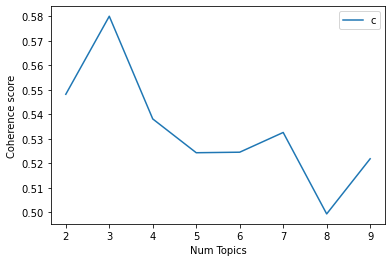

In [344]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [345]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5482
Num Topics = 3  has Coherence Value of 0.58
Num Topics = 4  has Coherence Value of 0.5381
Num Topics = 5  has Coherence Value of 0.5243
Num Topics = 6  has Coherence Value of 0.5245
Num Topics = 7  has Coherence Value of 0.5326
Num Topics = 8  has Coherence Value of 0.4994
Num Topics = 9  has Coherence Value of 0.5219


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [203]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [204]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('learn', 0.10453528574333944),
   ('ibm', 0.06589383770591824),
   ('lot', 0.04820012202562538),
   ('give', 0.03355704697986577),
   ('watson', 0.030913158429936954),
   ('experience', 0.028269269880008135),
   ('helpful', 0.0278625177954037),
   ('coursera', 0.023388244864754933),
   ('thing', 0.021964612568639415),
   ('teach', 0.01972747610331503)]),
 (1,
  [('easy', 0.04548959136468774),
   ('understand', 0.03508095605242868),
   ('make', 0.034309946029298384),
   ('week', 0.025443330763299923),
   ('complete', 0.02120277563608327),
   ('find', 0.019468003084040092),
   ('explanation', 0.017733230531996914),
   ('material', 0.01754047802621434),
   ('question', 0.01638396299151889),
   ('information', 0.015034695451040863)]),
 (2,
  [('assignment', 0.06472369417108251),
   ('final', 0.053747161241483724),
   ('work', 0.029901589704769114),
   ('project', 0.027819833459500377),
   ('instruction', 0.02668433005299016),
   ('time', 0.023088569265707796),
   ('cloud', 0.01911

In [346]:
# Create new column with the topic

df['topic'] = ''

df['topic'] = [max(p, key = lambda item: item[1]) for p in lda_model[corpus]]

In [347]:
# Create two separate columns for the topic ID and topic score

df[['topic_id', 'topic_score']] = df['topic'].apply(pd.Series)

In [348]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-11,"Interesting and clear, the difficulty in the e...",4,completer,186,pos,0.7957,pos,"[interest, clear, difficulty, exercise, escala...",interest clear difficulty exercise escalate pr...,"(0, 0.7999046)",0.0,0.799905
1,2021-03-11,"great, i have learned basics of python from th...",5,completer,56,pos,0.6249,pos,"[learn, basic, python, course]",learn basic python course,"(0, 0.87557936)",0.0,0.875579
2,2021-03-10,Recommended,5,completer,11,pos,0.2023,pos,[recommend],recommend,"(0, 0.67394125)",0.0,0.673941
3,2021-03-10,excellent,5,completer,9,pos,0.5719,pos,[excellent],excellent,"(0, 0.6836881)",0.0,0.683688
4,2021-03-10,Tamada sir is my biggest inspiration to comple...,5,completer,102,pos,0.5267,pos,"[tamada, sir, big, inspiration, complete, cour...",tamada sir big inspiration complete courseinsp...,"(2, 0.7478987)",2.0,0.747899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,2018-08-08,Good overall if you already have a grasp of py...,3,dropout,135,neu,0.1027,pos,"[overall, already, grasp, python, lot, mistake...",overall already grasp python lot mistake coher...,"(2, 0.47517183)",2.0,0.475172
3019,2018-08-06,good introductory course,5,dropout,24,pos,0.4404,pos,"[introductory, course]",introductory course,"(0, 0.788395)",0.0,0.788395
3020,2018-08-03,robotic teaching,2,dropout,16,neg,0.0000,neu,"[robotic, teaching]",robotic teaching,"(2, 0.7907945)",2.0,0.790794
3021,2018-08-03,I recommend!,5,dropout,12,pos,0.4199,pos,[recommend],recommend,"(0, 0.6739331)",0.0,0.673933


## Evaluation

In [349]:
df.loc[df['topic_id'] == 0.0]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-11,"Interesting and clear, the difficulty in the e...",4,completer,186,pos,0.7957,pos,"[interest, clear, difficulty, exercise, escala...",interest clear difficulty exercise escalate pr...,"(0, 0.7999046)",0.0,0.799905
1,2021-03-11,"great, i have learned basics of python from th...",5,completer,56,pos,0.6249,pos,"[learn, basic, python, course]",learn basic python course,"(0, 0.87557936)",0.0,0.875579
2,2021-03-10,Recommended,5,completer,11,pos,0.2023,pos,[recommend],recommend,"(0, 0.67394125)",0.0,0.673941
3,2021-03-10,excellent,5,completer,9,pos,0.5719,pos,[excellent],excellent,"(0, 0.6836881)",0.0,0.683688
5,2021-03-10,good and easy learning,3,completer,22,neu,0.7003,pos,"[easy, learning]",easy learning,"(0, 0.7703181)",0.0,0.770318
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,2018-08-15,Great fundamentals,5,dropout,18,pos,0.6249,pos,[fundamental],fundamental,"(0, 0.6781362)",0.0,0.678136
3017,2018-08-14,Thank you very much cousera and IBM.,5,dropout,36,pos,0.3612,pos,"[thank, much, cousera, ibm]",thank much cousera ibm,"(0, 0.8631796)",0.0,0.863180
3019,2018-08-06,good introductory course,5,dropout,24,pos,0.4404,pos,"[introductory, course]",introductory course,"(0, 0.788395)",0.0,0.788395
3021,2018-08-03,I recommend!,5,dropout,12,pos,0.4199,pos,[recommend],recommend,"(0, 0.6739331)",0.0,0.673933


In [350]:
df.loc[df['topic_id'] == 1.0]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
10,2021-03-09,The class goes too fast. Week 5 was particular...,3,completer,126,neu,0.2247,pos,"[class, go, fast, week, 5, particularly, chall...",class go fast week 5 particularly challenging ...,"(1, 0.906125)",1.0,0.906125
12,2021-03-08,perfect.Thanks you very much,5,completer,29,pos,0.0000,neu,"[perfectthanks, much]",perfectthanks much,"(1, 0.77228904)",1.0,0.772289
24,2021-03-05,Quiz questions sometimes pop-up before the sub...,3,completer,139,neu,0.0000,neu,"[quiz, question, sometimes, popup, subject, ma...",quiz question sometimes popup subject material...,"(1, 0.9561695)",1.0,0.956169
25,2021-03-04,"Let's be honest, no one without any experience...",2,dropout,978,neg,0.8414,pos,"[let, honest, one, without, experience, progra...",let honest one without experience programming ...,"(1, 0.5665765)",1.0,0.566576
27,2021-03-04,Some modules seemed disjointed and this shows ...,4,completer,488,pos,-0.3612,neg,"[module, seem, disjointed, show, lab, session,...",module seem disjointed show lab session diffic...,"(1, 0.6851488)",1.0,0.685149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,2018-09-07,"the material and movies were good, response fr...",3,dropout,273,neu,-0.3400,neg,"[material, movie, response, teacher, question,...",material movie response teacher question terri...,"(1, 0.9757555)",1.0,0.975756
3002,2018-08-31,"No support from moderators, plenty of typos.",1,completer,44,neg,0.1280,pos,"[support, moderator, plenty, typo]",support moderator plenty typo,"(1, 0.8664161)",1.0,0.866416
3007,2018-08-24,"Great course, perfect in explaining Python. Sm...",4,dropout,89,pos,0.8316,pos,"[course, perfect, explain, python, small, issu...",course perfect explain python small issue subm...,"(1, 0.5641982)",1.0,0.564198
3011,2018-08-20,Final Assignment quite con,5,dropout,26,pos,0.0000,neu,"[final, assignment, quite, con]",final assignment quite con,"(1, 0.67692435)",1.0,0.676924


In [351]:
df.loc[df['topic_id'] == 2.0].tail(50)

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
2790,2019-02-07,Easy to follow. A good starter for those witho...,5,completer,64,pos,0.7003,pos,"[easy, follow, starter, without, csie, backgroud]",easy follow starter without csie backgroud,"(2, 0.8903224)",2.0,0.890322
2796,2019-02-03,"Assignment is definitely tricky, given the pre...",5,completer,134,pos,0.7717,pos,"[assignment, definitely, tricky, give, preceed...",assignment definitely tricky give preceeding c...,"(2, 0.8346677)",2.0,0.834668
2804,2019-01-30,The course content is great but the peer revie...,3,completer,350,neu,0.5789,pos,"[course, content, peer, review, exam, confuse,...",course content peer review exam confuse bring ...,"(2, 0.7685469)",2.0,0.768547
2819,2019-01-22,Great environment CC - labs for learning pytho...,5,completer,85,pos,0.8481,pos,"[environment, cc, lab, learn, python, example,...",environment cc lab learn python example enjoed...,"(2, 0.65401417)",2.0,0.654014
2835,2019-01-13,content is good but it should be more descriptive,4,completer,49,pos,0.2382,pos,"[content, descriptive]",content descriptive,"(2, 0.7923109)",2.0,0.792311
2838,2019-01-12,The content is useful however there are quite ...,4,dropout,88,pos,0.0314,pos,"[content, useful, however, quite, mistakes, pr...",content useful however quite mistakes presenta...,"(2, 0.9153498)",2.0,0.915350
2841,2019-01-11,Good content.,5,completer,13,pos,0.4404,pos,[content],content,"(2, 0.68198866)",2.0,0.681989
2854,2019-01-03,It is amazing how bad this is considering that...,1,dropout,551,neg,-0.2783,neg,"[amaze, bad, consider, marketed, ibm, product,...",amaze bad consider marketed ibm product level ...,"(2, 0.7476551)",2.0,0.747655
2857,2019-01-02,Course content and section quizzes are bit too...,4,completer,160,pos,0.0000,neu,"[course, content, section, quiz, simple, compa...",course content section quiz simple compare fin...,"(2, 0.6667281)",2.0,0.666728
2869,2018-12-23,assignment are of good quality.,5,completer,31,pos,0.4404,pos,"[assignment, quality]",assignment quality,"(2, 0.5589588)",2.0,0.558959


In [352]:
df_final = df.drop(['joined', 'topic'], axis = 1)

In [353]:
df_final

,date,review,rating,status,length,label,compound,sentiment,preprocessed,topic_id,topic_score
0,2021-03-11,"Interesting and clear, the difficulty in the e...",4,completer,186,pos,0.7957,pos,"[interest, clear, difficulty, exercise, escala...",0.0,0.799905
1,2021-03-11,"great, i have learned basics of python from th...",5,completer,56,pos,0.6249,pos,"[learn, basic, python, course]",0.0,0.875579
2,2021-03-10,Recommended,5,completer,11,pos,0.2023,pos,[recommend],0.0,0.673941
3,2021-03-10,excellent,5,completer,9,pos,0.5719,pos,[excellent],0.0,0.683688
4,2021-03-10,Tamada sir is my biggest inspiration to comple...,5,completer,102,pos,0.5267,pos,"[tamada, sir, big, inspiration, complete, cour...",2.0,0.747899
...,...,...,...,...,...,...,...,...,...,...,...
3018,2018-08-08,Good overall if you already have a grasp of py...,3,dropout,135,neu,0.1027,pos,"[overall, already, grasp, python, lot, mistake...",2.0,0.475172
3019,2018-08-06,good introductory course,5,dropout,24,pos,0.4404,pos,"[introductory, course]",0.0,0.788395
3020,2018-08-03,robotic teaching,2,dropout,16,neg,0.0000,neu,"[robotic, teaching]",2.0,0.790794
3021,2018-08-03,I recommend!,5,dropout,12,pos,0.4199,pos,[recommend],0.0,0.673933


In [354]:
# Save dataframe as a csv file

df_final.to_csv('python-for-data-final.csv')